In [1]:
#Importações
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Parâmetros Do artigo

In [2]:
P = 520e-9            # pixel pitch [m]
wavelength = 1064e-9  # comprimento de onda [m]
supercell_pixels = 45 # pixels por supercelula
n_supercells = 10     # número de supercelulas por lado
iters_gs = 400        # iterações GS
random_seed = 0

Aqui definimos as dimensões e escalas

In [3]:
np.random.seed(random_seed)

N_super = supercell_pixels #Pixels por supercélula
N_total = N_super * n_supercells #Pixels totais da metassuperfície
dx = P #Pitch físico de cada pixel
d = dx * N_super #Período da supercélula 

Aqui construimos as grades de frequencias espaciais k-space para a supercélula. k_rad é o raio os espaço das frequências, usado para definir a região alvo

In [4]:
#Grade k
kx = np.fft.fftfreq(N_super, d=dx)
ky = np.fft.fftfreq(N_super, d=dx)
kx_shift = np.fft.fftshift(kx)
ky_shift = np.fft.fftshift(ky)
KX, KY = np.meshgrid(kx_shift, ky_shift)
K_rad = np.sqrt(KX**2 + KY**2)

Nesse trecho definimos um círculo de raio limitado no espaço k de fourier. Esse círculo represente um cone angular acessível pela metassuperfície (NA)

In [5]:
#Alvo no espaço k
target_radius = min(1.0 / wavelength, 1.0 / (2.0 * dx))
target_amp = (K_rad <= target_radius).astype(float)

Aqui aplicamos o GS na supercélula. No loop temos:

1-Calcula FFT (far-field da supercélula).

2-Mede erro RMSE entre amplitude atual e alvo (target_amp).

3-Substitui amplitude pela do alvo (círculo uniforme), mantém fase.

4-IFFT → volta ao plano da supercélula.

5-Impõe fase-only no plano da supercélula.

6-No final → obtemos a fase otimizada para distribuir energia uniformemente no far-field.


In [6]:
# campo inicial
plane_field = np.exp(1j * 2.0 * np.pi * np.random.rand(N_super, N_super))

errors = []
for it in range(iters_gs):
    far = np.fft.fft2(plane_field)
    far_shift = np.fft.fftshift(far)

    # erro RMSE
    amp_current = np.abs(far_shift)
    err = np.sqrt(np.mean((amp_current/amp_current.max() - target_amp)**2))
    errors.append(err)

    # aplicar restrição de amplitude
    far_shift = target_amp * np.exp(1j * np.angle(far_shift))
    far = np.fft.ifftshift(far_shift)

    plane_field = np.fft.ifft2(far)
    plane_field = np.exp(1j * np.angle(plane_field))

Nessa seção extraimos o mapa de fase da supercélula 45x45 e construimos a metassuperfície completa a partir da reprodução da supercélula em mosaico. 
Esspe padrão periódico cria pontos discretos no far-field


In [7]:
supercell_phase = np.angle(plane_field) #Extração do mapa de fase da supercélula
 
# tile
full_phase = np.tile(supercell_phase, (n_supercells, n_supercells))
full_field = np.exp(1j * full_phase)

Neste trecho calculamos a intensidade do far-field da metassuperfície.
Normalizamos e aplicamos log10 para visualizar o padrão dos pontos

In [8]:
# far-field
FF_full = np.fft.fft2(full_field)
FF_full_shift = np.fft.fftshift(FF_full)
I_far = np.abs(FF_full_shift)**2
I_far_plot = np.log10(I_far/I_far.max() + 1e-12)

Aqui calculamos quais ordens de difração (p,q) são propagantes dentro do cone angular.
Para cada ordem válida, mede-se a intensidade no far-field. Isso gera a lista de ordens e suas intensidades reais.

In [9]:
# ordens propagantes
p_max = int(np.floor(d / wavelength + 1e-12))
orders, intensities = [], []

kx_full = np.fft.fftfreq(N_total, d=dx)
ky_full = np.fft.fftfreq(N_total, d=dx)
kx_full_shift = np.fft.fftshift(kx_full)
ky_full_shift = np.fft.fftshift(ky_full)

for p in range(-p_max, p_max + 1):
    for q in range(-p_max, p_max + 1):
        sx, sy = p*wavelength/d, q*wavelength/d
        if (sx**2 + sy**2) <= 1.0 + 1e-12:
            fx_target, fy_target = p/d, q/d
            ix = np.argmin(np.abs(kx_full_shift - fx_target))
            iy = np.argmin(np.abs(ky_full_shift - fy_target))
            val = I_far[iy, ix]
            orders.append((p, q))
            intensities.append(val)

Aqui calculamos a eficiência de difração e o RMSE como uniformidade das intensidades.
O dataframe foi montado para uma possível análise estatística e plot.

In [10]:
intensities = np.array(intensities)
M = len(intensities)

# métricas
total_energy = I_far.sum()
de_sum = intensities.sum() / total_energy
mean_I = intensities.mean()
rmse = np.sqrt(np.mean((intensities/mean_I - 1.0)**2))

df = pd.DataFrame(orders, columns=['p','q'])
df['intensity'] = intensities

Por fim, temos os plots de gráficos que achamos relevamentes

Obs:O plot do tile é redundante uma vez que já temos a fase da supercélula, porém é uma forma de visualizar a fase da metassuperfície

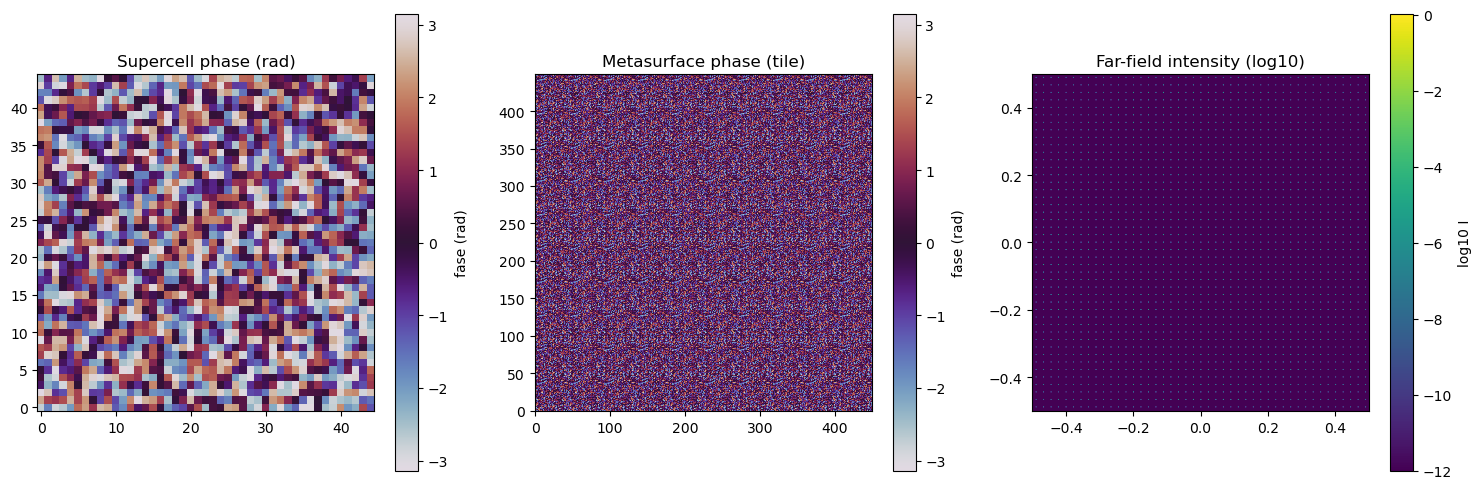

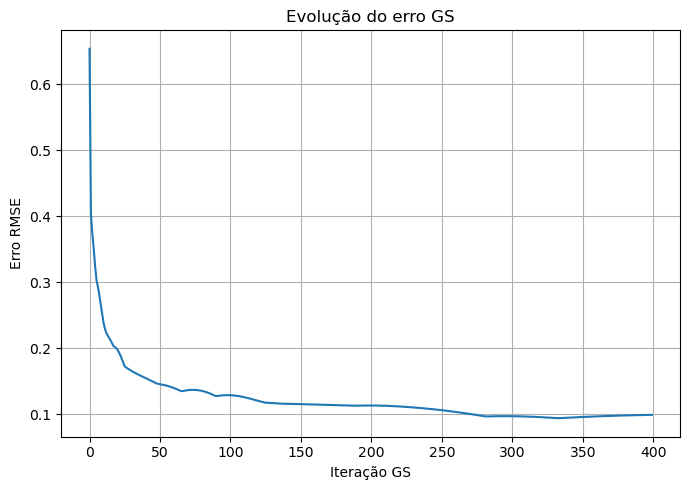

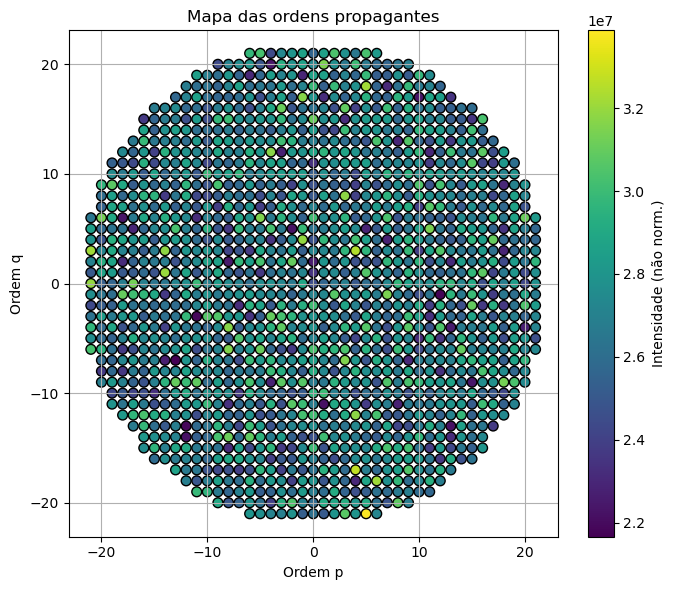

In [12]:
#Mapas de fase e difração
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Supercell phase (rad)")
plt.imshow(supercell_phase, cmap='twilight', origin='lower')
plt.colorbar(label='fase (rad)')

plt.subplot(1,3,2)
plt.title("Metasurface phase (tile)")
plt.imshow(full_phase, cmap='twilight', origin='lower')
plt.colorbar(label='fase (rad)')

plt.subplot(1,3,3)
plt.title("Far-field intensity (log10)")
plt.imshow(I_far_plot, origin='lower', extent=[-0.5,0.5,-0.5,0.5])
plt.colorbar(label='log10 I')
plt.tight_layout()
plt.savefig("mapas_fase_difracao.png", dpi=300)  
plt.show()

# evolução do erro
plt.figure(figsize=(7,5))
plt.plot(errors)
plt.xlabel("Iteração GS")
plt.ylabel("Erro RMSE")
plt.title("Evolução do erro GS")
plt.grid(True)
plt.tight_layout()
plt.savefig("evolucao_erro.png", dpi=300)
plt.show()

# scatter das ordens
plt.figure(figsize=(7,6))
sc = plt.scatter(df['p'], df['q'], c=df['intensity'], cmap='viridis', s=50, edgecolor="k")
plt.colorbar(sc, label="Intensidade (não norm.)")
plt.xlabel("Ordem p")
plt.ylabel("Ordem q")
plt.title("Mapa das ordens propagantes")
plt.grid(True)
plt.tight_layout()
plt.savefig("ordens_propagantes.png", dpi=300)
plt.show()
